In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from functools import partial

def init_network(key, input_dim=10, hidden_dim=32, output_dim=1, weights_prefix=""):
    """Initialize a 3-layer network with ~1k parameters"""
    keys = random.split(key, 6)
    # Layer 1: input_dim -> hidden_dim
    W1 = random.normal(keys[0], (input_dim, hidden_dim)) * 0.1
    b1 = jnp.zeros(hidden_dim)

    # Layer 2: hidden_dim -> hidden_dim
    W2 = random.normal(keys[2], (hidden_dim, hidden_dim)) * 0.1
    b2 = jnp.zeros(hidden_dim)

    # Layer 3: hidden_dim -> output_dim
    W3 = random.normal(keys[4], (hidden_dim, output_dim)) * 0.1
    b3 = jnp.zeros(output_dim)

    params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    params = {f"{weights_prefix}{k}": v for k, v in params.items()}
    # Count parameters
    total_params = sum(p.size for p in jax.tree.leaves(params))
    print(f"Total parameters: {total_params}")

    return params

def forward(params, x, weights_prefix=""):
    """Forward pass through the network"""
    # Layer 1
    h1 = jnp.tanh(jnp.dot(x, params[f'{weights_prefix}W1']) + params[f'{weights_prefix}b1'])

    # Layer 2
    h2 = jnp.tanh(jnp.dot(h1, params[f'{weights_prefix}W2']) + params[f'{weights_prefix}b2'])

    # Layer 3 (output)
    logits = jnp.dot(h2, params[f'{weights_prefix}W3']) + params[f'{weights_prefix}b3']

    return logits.squeeze()

def binary_cross_entropy_loss(params, x, y, weights_prefix=""):
    """Binary cross-entropy loss"""
    logits = forward(params, x, weights_prefix)
    # Sigmoid + BCE in numerically stable way
    return jnp.mean(jnp.maximum(logits, 0) - logits * y + jnp.log(1 + jnp.exp(-jnp.abs(logits))))

def accuracy(params, x, y, weights_prefix=""):
    """Calculate accuracy"""
    logits = forward(params, x, weights_prefix)
    predictions = (logits > 0).astype(jnp.float32)
    return jnp.mean(predictions == y)

@partial(jit, static_argnames=['weights_prefix'])
def update_step(params, x, y, learning_rate=0.01, weights_prefix=""):
    """Single gradient descent step"""
    loss_val, grads = jax.value_and_grad(binary_cross_entropy_loss)(params, x, y, weights_prefix)

    # Update parameters
    updated_params = jax.tree.map(lambda p, g: p - learning_rate * g, params, grads)

    return updated_params, loss_val

def generate_data(key, n_samples=1000, input_dim=10):
    """Generate synthetic binary classification data"""
    keys = random.split(key, 3)

    X_bg = random.normal(keys[0], (int(n_samples/2), input_dim)) * 0.1
    X_sig = random.normal(keys[1], (int(n_samples/2), input_dim)) * 0.1 + 5.0

    X = jnp.vstack((X_bg, X_sig))
    y = jnp.concatenate((jnp.zeros(int(n_samples/2)), jnp.ones(int(n_samples/2))))

    return X, y

# Training loop
def train_network():
    key = random.PRNGKey(42)
    keys = random.split(key, 3)

    # Generate data
    X_train, y_train = generate_data(keys[0], n_samples=800)
    X_test, y_test = generate_data(keys[1], n_samples=200)

    # Initialize network
    params = init_network(keys[2], input_dim=X_train.shape[1])

    # Training
    learning_rate = 0.01
    n_epochs = 1000

    for epoch in range(n_epochs):
        params, loss = update_step(params, X_train, y_train, learning_rate)

        if epoch % 100 == 0:
            train_acc = accuracy(params, X_train, y_train)
            test_acc = accuracy(params, X_test, y_test)
            print(f"Epoch {epoch}: Loss = {loss:.4f}, Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

    return params, X_test, y_test

# Saving and loading functions
import pickle
import numpy as np

def save_model_pickle(params, filepath):
    """Save model parameters using pickle"""
    # Convert JAX arrays to numpy for serialization
    numpy_params = jax.tree.map(np.array, params)
    with open(filepath, 'wb') as f:
        pickle.dump(numpy_params, f)
    print(f"Model saved to {filepath}")

def load_model_pickle(filepath):
    """Load model parameters from pickle file"""
    with open(filepath, 'rb') as f:
        numpy_params = pickle.load(f)
    # Convert back to JAX arrays
    params = jax.tree.map(jnp.array, numpy_params)
    return params


# Run training
if __name__ == "__main__":
    trained_params, X_test, y_test = train_network()

    # Final evaluation
    final_accuracy = accuracy(trained_params, X_test, y_test)
    print(f"\nFinal test accuracy: {final_accuracy:.4f}")

    # Save the model using different methods
    print("\nSaving model...")

    # Method 1: Simple pickle
    save_model_pickle(trained_params, "model.pkl")

    # Demonstrate loading
    print("\nLoading model...")
    loaded_params = load_model_pickle("model.pkl")


Total parameters: 1441
Epoch 0: Loss = 0.7112, Train Acc = 0.2625, Test Acc = 0.2300
Epoch 100: Loss = 0.4060, Train Acc = 1.0000, Test Acc = 1.0000
Epoch 200: Loss = 0.2658, Train Acc = 1.0000, Test Acc = 1.0000
Epoch 300: Loss = 0.1673, Train Acc = 1.0000, Test Acc = 1.0000
Epoch 400: Loss = 0.1058, Train Acc = 1.0000, Test Acc = 1.0000
Epoch 500: Loss = 0.0702, Train Acc = 1.0000, Test Acc = 1.0000
Epoch 600: Loss = 0.0495, Train Acc = 1.0000, Test Acc = 1.0000
Epoch 700: Loss = 0.0368, Train Acc = 1.0000, Test Acc = 1.0000
Epoch 800: Loss = 0.0286, Train Acc = 1.0000, Test Acc = 1.0000
Epoch 900: Loss = 0.0231, Train Acc = 1.0000, Test Acc = 1.0000

Final test accuracy: 1.0000

Saving model...
Model saved to model.pkl

Loading model...


In [2]:
# load the data from the uproot files
import uproot
import warnings
import numpy as np
import awkward as ak
import vector
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory

NanoAODSchema.warn_missing_crossrefs = False
warnings.filterwarnings("ignore", category=FutureWarning, module="coffea.*")

In [3]:
# variables into memory (takes ~1min)
# semilep only in analysis code
file_dict = {
    "wjets": "preproc_uproot/z-prime-ttbar-data/wjets__nominal/file__0/part0.root",
    "ttbar_had": "preproc_uproot/z-prime-ttbar-data/ttbar_had__nominal/file__0/part0.root",
    "ttbar_lep": "preproc_uproot/z-prime-ttbar-data/ttbar_lep__nominal/file__0/part0.root",
    "ttbar_semilep": "preproc_uproot/z-prime-ttbar-data/ttbar_semilep__nominal/file__0/part0.root",
    "signal": "preproc_uproot/z-prime-ttbar-data/signal__nominal/file__0/part0.root",
}

data = {}
for proc, file_path in file_dict.items():
    print(f"Processing {proc}...")
    data[proc] = {}
    events = NanoEventsFactory.from_root(
        f"{file_path}:Events", schemaclass=NanoAODSchema, delayed=False,
    ).events()

    # good object corrections
    jets, muons = events.Jet, events.Muon

    # object filters were in analysis code
    muons = muons[
        (muons.pt > 55)
        & (abs(muons.eta) < 2.4)
        & muons.tightId
        & (muons.miniIsoId > 1)
    ]

    jets = jets #[
    #     (jets.jetId >= 4)
    #     & (jets.btagDeepB > 0.5)
    # ]

    # require at least 2 jets and exaclty 1 muon
    mask = (ak.num(jets, axis=1) >= 2) & (ak.num(muons, axis=1) == 1)
    muons = muons[mask]
    jets = jets[mask]
    fatjet = events.FatJet[mask]
    met = events.PuppiMET[mask]

    print(f"Number of events after selection for {proc}: {len(met)}")

    # number of jets
    data[proc]["n_jet"] = ak.num(jets, axis=1).to_numpy()

    # leading and subleading jet mass
    data[proc]["leading_jet_mass"] = jets.mass[:, 0].to_numpy()
    data[proc]["subleading_jet_mass"] = jets.mass[:, 1].to_numpy()

    # scalar sum ST
    data[proc]["st"] = (
        ak.sum(jets.pt, axis=1) + ak.sum(muons.pt, axis=1)
    ).to_numpy()

    # leading and subleading jet b-tag score
    data[proc]["leading_jet_btag_score"] = jets.btagDeepB[:, 0].to_numpy()
    data[proc]["subleading_jet_btag_score"] = jets.btagDeepB[:, 1].to_numpy()

    # Sphericity tensor (only zz component)
    denominator = ak.sum(jets.px**2 + jets.py**2 + jets.pz**2, axis=1)
    S_zz = ak.sum(jets.pz * jets.pz, axis=1) / denominator
    data[proc]["S_zz"] = S_zz.to_numpy()

    # deltaR between muon and closest jet
    muon_in_pair, jet_in_pair = ak.unzip(ak.cartesian([muons, jets]))
    delta_r = muon_in_pair.deltaR(jet_in_pair)
    min_delta_r = ak.min(delta_r, axis=1)
    data[proc]["deltaR"] = min_delta_r.to_numpy()

    # transverse momentum of the muon w.r.t. the axis of the nearest jet (pt_rel)
    min_delta_r_indices = ak.argmin(delta_r, axis=1, keepdims=True)
    angle = muons.deltaangle(jet_in_pair[min_delta_r_indices])
    data[proc]["pt_rel"] = (muons.p * np.sin(angle)).to_numpy().flatten()

    # deltaR between muon and closest jet times the jet pt
    min_delta_r_indices = ak.argmin(delta_r, axis=1, keepdims=True)
    closest_jet_pt = jet_in_pair.pt[min_delta_r_indices]
    data[proc]["deltaR_times_pt"] = (min_delta_r * closest_jet_pt).to_numpy().flatten()


Processing wjets...
Number of events after selection for wjets: 167219
Processing ttbar_had...
Number of events after selection for ttbar_had: 29798
Processing ttbar_lep...
Number of events after selection for ttbar_lep: 5579561
Processing ttbar_semilep...
Number of events after selection for ttbar_semilep: 8306068
Processing signal...
Number of events after selection for signal: 62691


In [4]:
cd6 = {
    "blue": "#5790fc",
    "orange": "#f89c20",
    "red": "#e42536",
    "violet": "#964a8b",
    "gray": "#9c9ca1",
    "purple": "#7a21dd",
}

process_color_dict = {
    "wjets": cd6["blue"],
    "ttbar_had": cd6["red"],
    "ttbar_lep": cd6["orange"],
    "ttbar_semilep": cd6["purple"],
    "ttbar": cd6["red"],
    "signal": cd6["violet"],
}

model_color_dict = {}

In [5]:
processes = list(data.keys())
variables = list(data[processes[0]].keys())

data["ttbar"] = {}
for var in variables:
    data["ttbar"][var] = np.concatenate([data[p][var] for p in ["ttbar_had", "ttbar_lep", "ttbar_semilep"] if p in data])


Plotting n_jet
label: wjets, shape: (167219,), min: 2, max: 19
label: ttbar, shape: (13915427,), min: 2, max: 26
label: signal, shape: (62691,), min: 2, max: 21


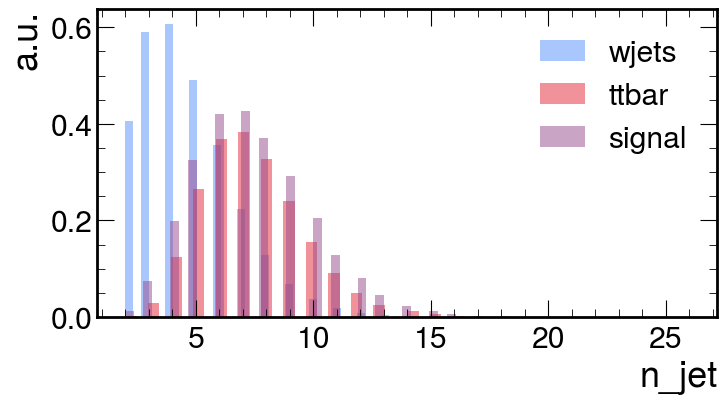

Plotting leading_jet_mass
label: wjets, shape: (167219,), min: -2.1576881408691406e-05, max: 156.75
label: ttbar, shape: (13915427,), min: -0.485107421875, max: 382.25
label: signal, shape: (62691,), min: 2.1576881408691406e-05, max: 414.75


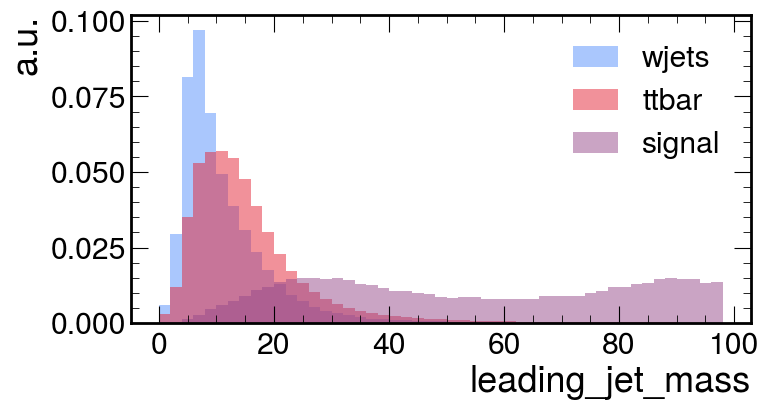

Plotting subleading_jet_mass
label: wjets, shape: (167219,), min: -1.0788440704345703e-05, max: 179.625
label: ttbar, shape: (13915427,), min: -0.25439453125, max: 432.5
label: signal, shape: (62691,), min: -0.1536865234375, max: 259.5


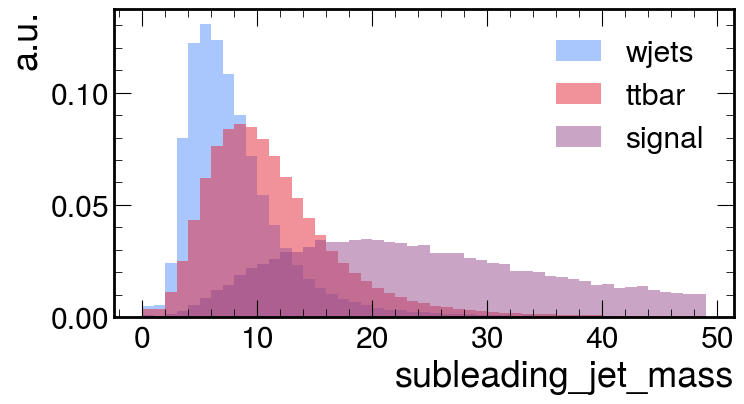

Plotting st
label: wjets, shape: (167219,), min: 126.78040313720703, max: 3769.71923828125
label: ttbar, shape: (13915427,), min: 129.58010864257812, max: 8172.306640625
label: signal, shape: (62691,), min: 206.13079833984375, max: 5272.0712890625


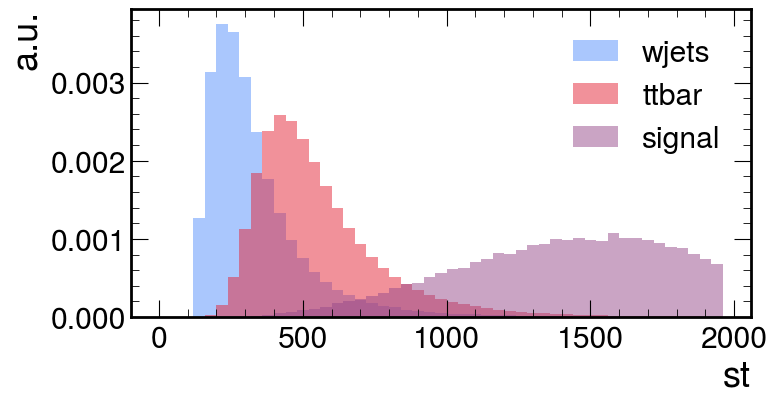

Plotting leading_jet_btag_score
label: wjets, shape: (167219,), min: -1.0, max: 0.99951171875
label: ttbar, shape: (13915427,), min: -1.0, max: 1.0
label: signal, shape: (62691,), min: -1.0, max: 0.99951171875


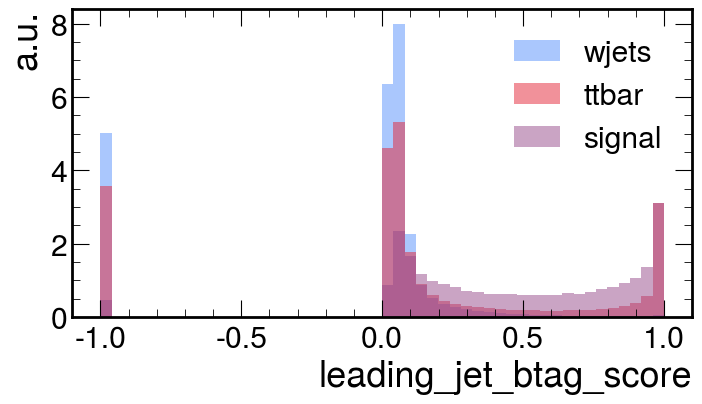

Plotting subleading_jet_btag_score
label: wjets, shape: (167219,), min: -1.0, max: 0.99951171875
label: ttbar, shape: (13915427,), min: -1.0, max: 1.0
label: signal, shape: (62691,), min: -1.0, max: 0.99951171875


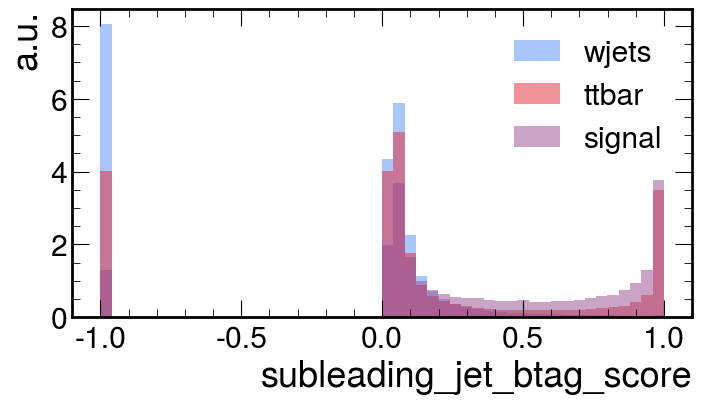

Plotting S_zz
label: wjets, shape: (167219,), min: 0.0002946410677395761, max: 0.999567985534668
label: ttbar, shape: (13915427,), min: 8.81735177244991e-05, max: 0.9998549818992615
label: signal, shape: (62691,), min: 0.0006027604686096311, max: 0.997674822807312


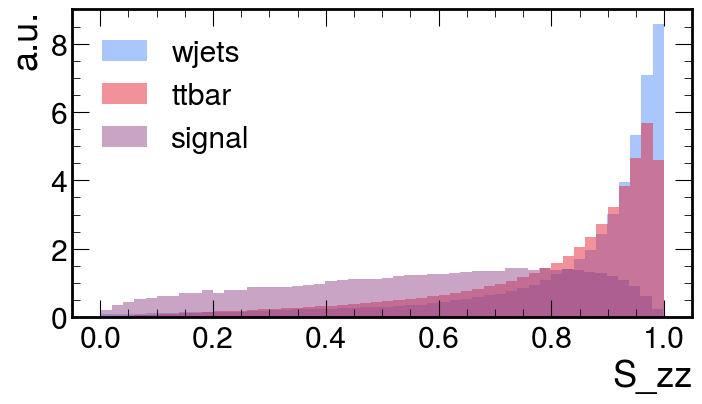

Plotting deltaR
label: wjets, shape: (167219,), min: 0.0, max: 0.34166935086250305
label: ttbar, shape: (13915427,), min: 0.0, max: 0.41115802526474
label: signal, shape: (62691,), min: 0.0, max: 0.37897083163261414


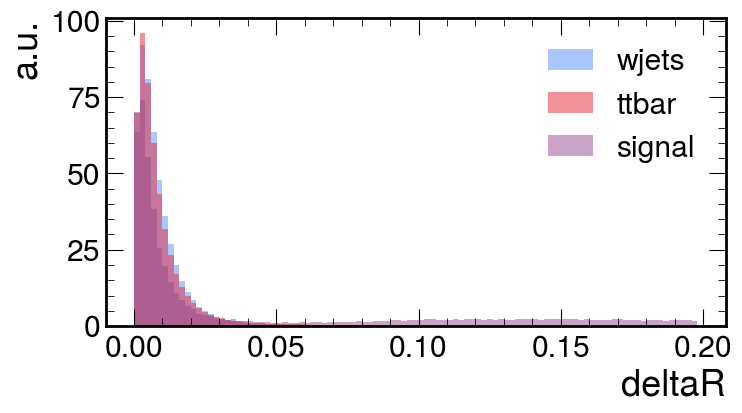

Plotting pt_rel
label: wjets, shape: (167219,), min: 0.0, max: 59.981689453125
label: ttbar, shape: (13915427,), min: 0.0, max: 98.22347259521484
label: signal, shape: (62691,), min: 0.0, max: 91.11966705322266


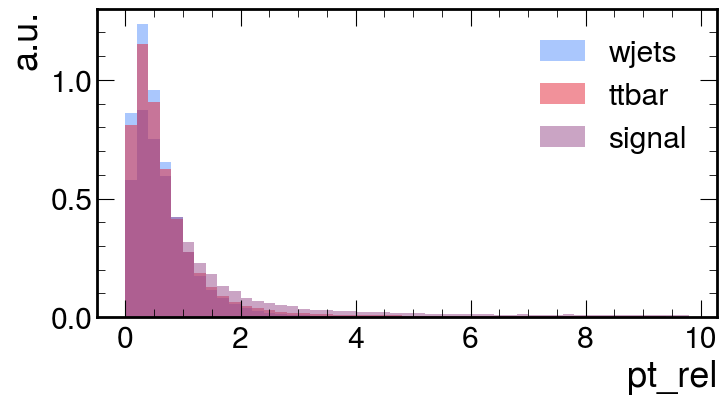

Plotting deltaR_times_pt
label: wjets, shape: (167219,), min: 0.0, max: 333.46929931640625
label: ttbar, shape: (13915427,), min: 0.0, max: 1867.1759033203125
label: signal, shape: (62691,), min: 0.0, max: 427.33294677734375


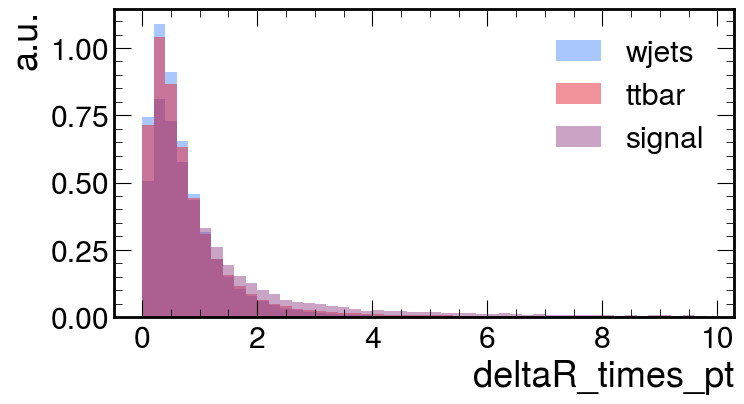

In [6]:
import importlib
from utils import drawing
importlib.reload(drawing)
draw = drawing.Draw(output_dir="output/plots/", interactive=True)
draw.process_color_dict = process_color_dict

binnings = {
    "n_jet": 50,
    "leading_jet_mass": range(0, 100, 2),
    "subleading_jet_mass": range(0, 50, 1),
    "st": range(0, 2000, 40),
    "leading_jet_btag_score": 50,
    "subleading_jet_btag_score": 50,
    "S_zz": 50,
    "deltaR": np.arange(0, 0.2, 0.002),
    "pt_rel": np.arange(0, 10, 0.2),
    "deltaR_times_pt": np.arange(0, 10, 0.2),
}

for var, bins in binnings.items():
    draw.plot_simple_hist(
        {p: data[p][var] for p in ["wjets", "ttbar", "signal"]},
        bins=bins,
        x_label=var,
    )


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

var_scale_dict = {
    # "st": 1./500.,
    "n_jet": 1./10.,
    # "leading_jet_btag_score": 1.,
    "leading_jet_mass": 1./20.,
    "subleading_jet_mass": 1./10.,
    # "S_zz": 1.,
    # "deltaR": 20.,
}

# my_vars = ["st", "leading_jet_mass", "subleading_jet_mass", "S_zz", "deltaR", "pt_rel", "deltaR_times_pt"]

# X_wjets = np.column_stack([data["wjets"][var] for var in my_vars]).astype(float)
# X_ttbar = np.column_stack([data["ttbar"][var] for var in my_vars]).astype(float)

X_wjets = np.column_stack([data["wjets"][v]*s for v, s in var_scale_dict.items()]).astype(float)
X_ttbar = np.column_stack([data["ttbar"][v]*s for v, s in var_scale_dict.items()]).astype(float)
X_signal = np.column_stack([data["signal"][v]*s for v, s in var_scale_dict.items()]).astype(float)

y_wjets = np.zeros_like(data["wjets"]["n_jet"], dtype=float)
y_ttbar = np.ones_like(data["ttbar"]["n_jet"], dtype=float)

X = np.concatenate([X_wjets, X_ttbar[:len(X_wjets)]], axis=0)  # tiny model, so we can omit most ttbar events to create a balanced dataset
y = np.concatenate([y_wjets, y_ttbar[:len(y_wjets)]], axis=0)

X = jnp.array(X, dtype=jnp.float32)
y = jnp.array(y, dtype=jnp.float32)
#  class_weights = {0: 1.0, 1: np.sum(y==0) / np.sum(y==1)}  # (also tested with imbalanced datasets and sample weights: minimal gain. hence omitted)

# X = StandardScaler().fit_transform(X) # works quite well w/o scaling.

# shuffele and split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

(334438, 3) (334438,)


Plotting n_jet
label: wjets, shape: (167219,), min: 0.2, max: 1.9000000000000001
label: ttbar, shape: (13915427,), min: 0.2, max: 2.6


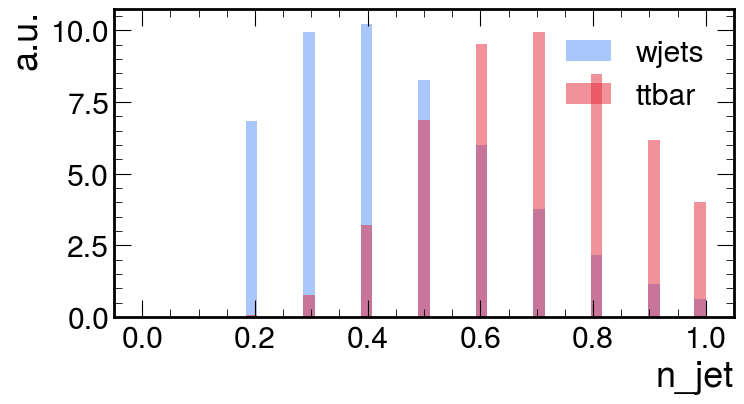

Plotting leading_jet_mass
label: wjets, shape: (167219,), min: -1.0788440931719379e-06, max: 7.837500095367432
label: ttbar, shape: (13915427,), min: -0.02425537072122097, max: 19.11250114440918


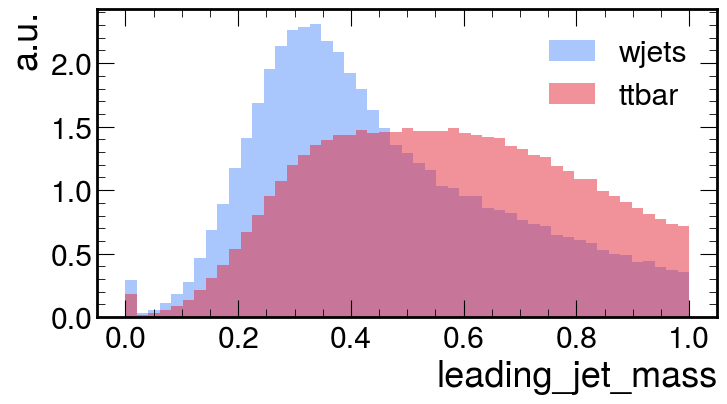

Plotting subleading_jet_mass
label: wjets, shape: (167219,), min: -1.0788440931719379e-06, max: 17.962499618530273
label: ttbar, shape: (13915427,), min: -0.02543945424258709, max: 43.25


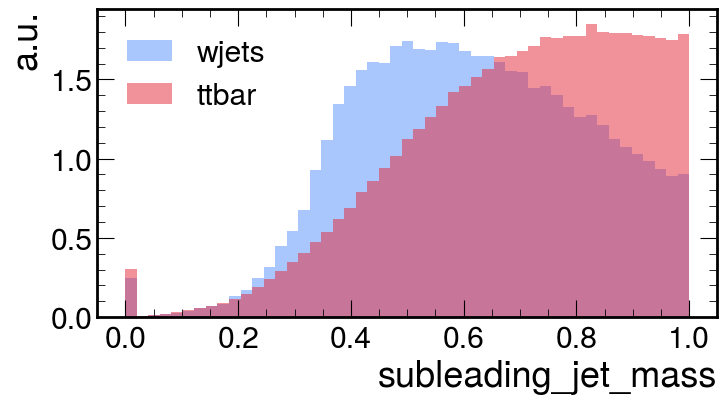

In [8]:
for i in range(X.shape[1]):
    X_wjets_var = X_wjets[:, i]
    X_ttbar_var = X_ttbar[:, i]
    X_var = {
        "wjets": X_wjets_var,
        "ttbar": X_ttbar_var,
        "signal": X_signal[:, i],
    }
    var = list(var_scale_dict.keys())[i]
    draw.plot_simple_hist(
        {p: X_var[p] for p in ["wjets", "ttbar"]},
        bins=np.linspace(0, 1, 50),
        x_label=var,
    )


In [9]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"{y_train.sum() / len(y_train) * 100:.2f}% of training samples are signal (ttbar)")
print(f"{y_test.sum() / len(y_test) * 100:.2f}% of training samples are signal (ttbar)")


X_train shape: (267550, 3), y_train shape: (267550,)
50.01% of training samples are signal (ttbar)
49.97% of training samples are signal (ttbar)


In [22]:
key = random.PRNGKey(42)
keys = random.split(key, 3)
# different usage of keys in init_network in the analysis code

# Initialize network
params = init_network(keys[2], input_dim=X_train.shape[1], hidden_dim=16, weights_prefix="__NN_wjets_vs_ttbar_nn_")

# print(f"Initialized parameters: {params}")

for key, value in params.items():
    print(f"{key}: {value.shape}")


Total parameters: 353
__NN_wjets_vs_ttbar_nn_W1: (3, 16)
__NN_wjets_vs_ttbar_nn_b1: (16,)
__NN_wjets_vs_ttbar_nn_W2: (16, 16)
__NN_wjets_vs_ttbar_nn_b2: (16,)
__NN_wjets_vs_ttbar_nn_W3: (16, 1)
__NN_wjets_vs_ttbar_nn_b3: (1,)


In [23]:
# Training
learning_rate = 0.02
n_epochs = 1000

history = {
    "loss": [],
    "train_acc": [],
    "test_acc": []
}

for epoch in range(n_epochs):
    params, loss = update_step(params, X_train, y_train, learning_rate, weights_prefix="__NN_wjets_vs_ttbar_nn_")
    history["loss"].append(loss)
    train_acc = accuracy(params, X_train, y_train, weights_prefix="__NN_wjets_vs_ttbar_nn_")
    test_acc = accuracy(params, X_test, y_test, weights_prefix="__NN_wjets_vs_ttbar_nn_")
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)

    if epoch % 100 == 0:
        train_acc = accuracy(params, X_train, y_train, weights_prefix="__NN_wjets_vs_ttbar_nn_")
        test_acc = accuracy(params, X_test, y_test, weights_prefix="__NN_wjets_vs_ttbar_nn_")
        print(f"Epoch {epoch}: Loss = {loss:.4f}, Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

# Final evaluation
final_accuracy = accuracy(params, X_test, y_test, weights_prefix="__NN_wjets_vs_ttbar_nn_")
print(f"\nFinal test accuracy: {final_accuracy:.4f}")

Epoch 0: Loss = 0.6943, Train Acc = 0.4993, Test Acc = 0.4996
Epoch 100: Loss = 0.6930, Train Acc = 0.4755, Test Acc = 0.4747
Epoch 200: Loss = 0.6917, Train Acc = 0.5016, Test Acc = 0.5015
Epoch 300: Loss = 0.6904, Train Acc = 0.5309, Test Acc = 0.5300
Epoch 400: Loss = 0.6890, Train Acc = 0.5778, Test Acc = 0.5762
Epoch 500: Loss = 0.6873, Train Acc = 0.6106, Test Acc = 0.6093
Epoch 600: Loss = 0.6854, Train Acc = 0.6324, Test Acc = 0.6307
Epoch 700: Loss = 0.6831, Train Acc = 0.6483, Test Acc = 0.6462
Epoch 800: Loss = 0.6804, Train Acc = 0.6591, Test Acc = 0.6580
Epoch 900: Loss = 0.6772, Train Acc = 0.6679, Test Acc = 0.6677

Final test accuracy: 0.6742


In [24]:
for key, value in params.items():
    print(f"{key}: {value.shape}")

# Final evaluation
final_accuracy = accuracy(params, X_test, y_test, weights_prefix="__NN_wjets_vs_ttbar_nn_")
print(f"\nFinal test accuracy: {final_accuracy:.4f}")

__NN_wjets_vs_ttbar_nn_W1: (3, 16)
__NN_wjets_vs_ttbar_nn_W2: (16, 16)
__NN_wjets_vs_ttbar_nn_W3: (16, 1)
__NN_wjets_vs_ttbar_nn_b1: (16,)
__NN_wjets_vs_ttbar_nn_b2: (16,)
__NN_wjets_vs_ttbar_nn_b3: (1,)

Final test accuracy: 0.6742


In [25]:
# Save the model using different methods
print("\nSaving model...")

# Method 1: Simple pickle
save_model_pickle(params, "model.pkl")



Saving model...
Model saved to model.pkl


In [26]:
for key, value in params.items():
    print(f"{key}: {value.shape}")

print(f"{X_test.shape=}")
scores = forward(params, X_test, weights_prefix="__NN_wjets_vs_ttbar_nn_")


__NN_wjets_vs_ttbar_nn_W1: (3, 16)
__NN_wjets_vs_ttbar_nn_W2: (16, 16)
__NN_wjets_vs_ttbar_nn_W3: (16, 1)
__NN_wjets_vs_ttbar_nn_b1: (16,)
__NN_wjets_vs_ttbar_nn_b2: (16,)
__NN_wjets_vs_ttbar_nn_b3: (1,)
X_test.shape=(66888, 3)


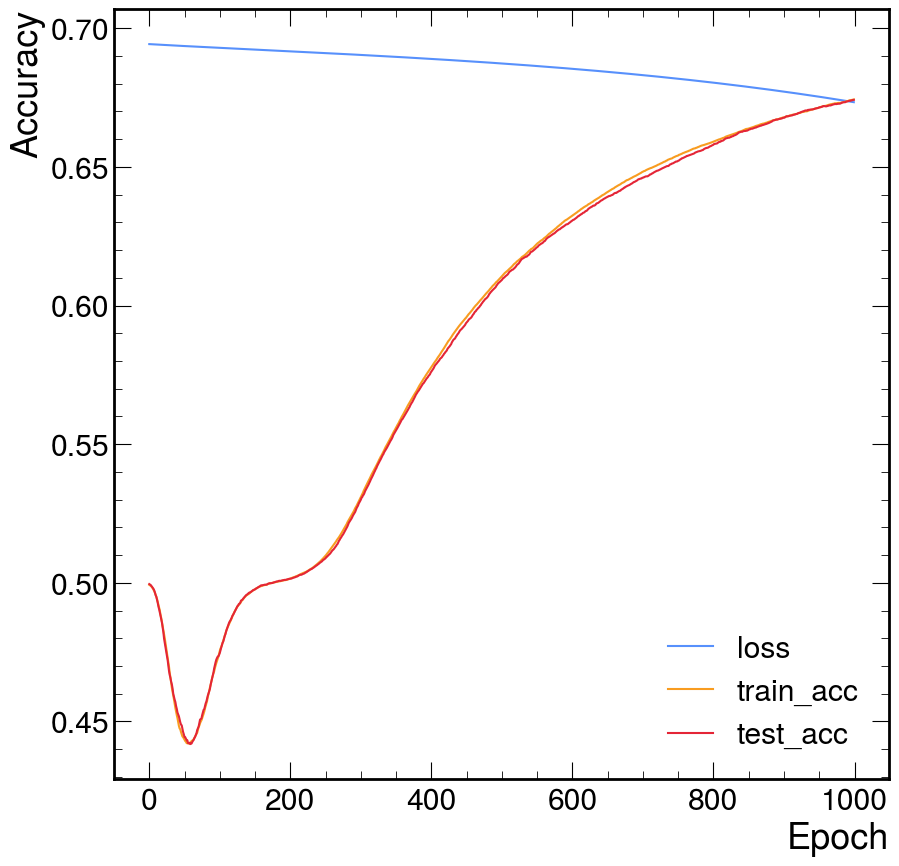

In [27]:
import matplotlib.pyplot as plt
plt.plot(history["loss"], label="loss")
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["test_acc"], label="test_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [28]:
# logits = forward(params, x)
# predictions = (logits > 0).astype(jnp.float32)
# return jnp.mean(predictions == y)


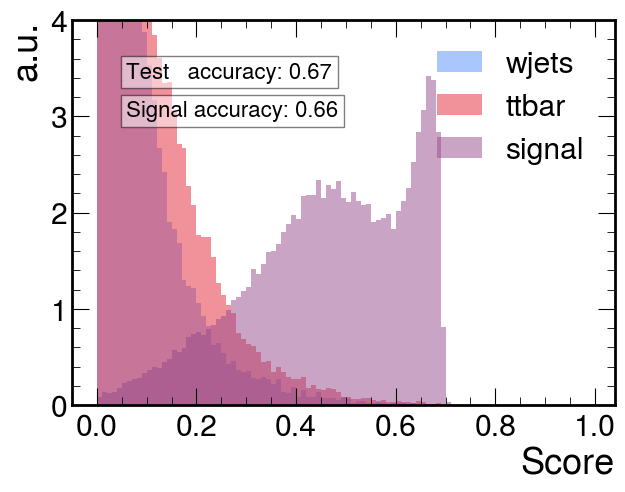

In [29]:
params = load_model_pickle("model.pkl")
wjets_score = forward(params, X_test[y_test==0],weights_prefix="__NN_wjets_vs_ttbar_nn_")
ttbar_score =  forward(params, X_test[y_test==1],weights_prefix="__NN_wjets_vs_ttbar_nn_")
signal_score = forward(params, X_signal,weights_prefix="__NN_wjets_vs_ttbar_nn_")
test_acc = accuracy(params, X_test, y_test,weights_prefix="__NN_wjets_vs_ttbar_nn_")

signal_acc = accuracy(
    params,
    np.concatenate([X_signal, X_test]),
    np.concatenate([np.ones(len(X_signal)), np.zeros(len(X_test))]),weights_prefix="__NN_wjets_vs_ttbar_nn_"
)

bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(7, 5))
plt.hist(
    wjets_score,
    # bins=np.arange(0, 1, 0.01),
    # alpha=0.5,
    bins=bins,
    label="wjets",
    color=process_color_dict["wjets"],
    alpha=0.5,
    density=True,
)
plt.hist(
    ttbar_score,
    # bins=np.arange(0, 1, 0.01),
    # alpha=0.5,
    bins=bins,
    label="ttbar",
    color=process_color_dict["ttbar"],
    alpha=0.5,
    density=True,
)
plt.hist(
    signal_score,
    # bins=np.arange(0, 1, 0.01),
    # alpha=0.5,
    bins=bins,
    label="signal",
    color=process_color_dict["signal"],
    alpha=0.5,
    density=True,
)
plt.xlabel("Score")
plt.ylabel("a.u.")
plt.gca().set_ylim(0, 4)
plt.legend()
plt.text(0.1, 0.85, f"Test   accuracy: {test_acc:.2f}",   transform=plt.gca().transAxes, fontsize=16, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.1, 0.75, f"Signal accuracy: {signal_acc:.2f}", transform=plt.gca().transAxes, fontsize=16, bbox=dict(facecolor='white', alpha=0.5))
plt.show()


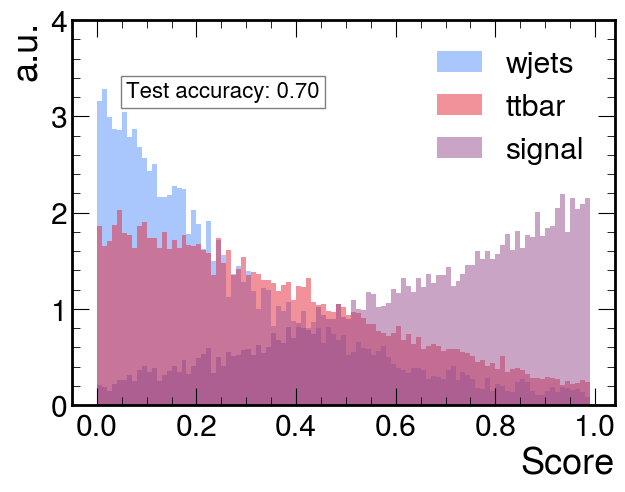

In [31]:
params = load_model_pickle("model-after-optimization.pkl")
params = load_model_pickle("output_with_mva/mva_models/wjets_vs_ttbar_nn.pkl") #_optimised

wjets_score = forward(params, X_test[y_test==0], weights_prefix="__NN_wjets_vs_ttbar_nn_")
ttbar_score =  forward(params, X_test[y_test==1], weights_prefix="__NN_wjets_vs_ttbar_nn_")
signal_score = forward(params, X_signal, weights_prefix="__NN_wjets_vs_ttbar_nn_")
test_acc = accuracy(params, X_test, y_test, weights_prefix="__NN_wjets_vs_ttbar_nn_")

signal_acc = accuracy(
    params,
    np.concatenate([X_signal, X_test]),
    np.concatenate([np.ones(len(X_signal)), np.zeros(len(X_test))]),
    weights_prefix="__NN_wjets_vs_ttbar_nn_"
)

bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(7, 5))
plt.hist(
    wjets_score,
    bins=bins,
    label="wjets",
    color=process_color_dict["wjets"],
    alpha=0.5,
    density=True,
)
plt.hist(
    ttbar_score,
    bins=bins,
    label="ttbar",
    color=process_color_dict["ttbar"],
    alpha=0.5,
    density=True,
)
plt.hist(
    signal_score,
    # bins=np.arange(0, 1, 0.01),
    # alpha=0.5,
    bins=bins,
    label="signal",
    color=process_color_dict["signal"],
    alpha=0.5,
    density=True,
)
plt.xlabel("Score")
plt.ylabel("a.u.")
# set ylim
plt.gca().set_ylim(0, 4)
plt.legend()
plt.text(0.1, 0.8, f"Test accuracy: {test_acc:.2f}", transform=plt.gca().transAxes, fontsize=16, bbox=dict(facecolor='white', alpha=0.5))
plt.show()
